In [ ]:
import warnings
warnings.filterwarnings('ignore')
import pickle
from helper_functions import show_distances_distributions, get_performance
import numpy as np
import face_recognition
import matplotlib.pyplot as plt
import cv2
import matplotlib.image as imreader
%matplotlib inline

## Loading training data

In [ ]:
face_db_path = "/home/asoriano/Stratio/spaceAI/evolution-vision/src/resources/faces-dbs/sp2-v1/spaceai-evolution-train-v2-raw.db"
with open(face_db_path, 'rb') as fp:
    face_db = pickle.load(fp)
train_face_names = face_db['names']
train_face_embeddings = face_db['embedding']
train_img_paths = face_db['images_path']
train_img_sizes = face_db['sizes']

In [ ]:
# · Getting number of samples and faces
n_samples = len(train_face_names)
n_faces = len(set(train_face_names))

print("- Number of samples: " + str(n_samples))
print("- Number of faces: " + str(n_faces))
print(set(train_face_names))

#### Image paths

In [ ]:
train_img_paths[0]

In [ ]:
tais_path_prefix  = "/mnt/hdd1tb/evolution-vision/face-recognition/resources/train_dir"
local_path_prefix = "/home/asoriano/Escritorio/Facial-sp2-v1"

In [ ]:
def local_path(path):
    return path.replace(tais_path_prefix, local_path_prefix)

#### Distances distribution

In [ ]:
show_distances_distributions(train_face_names, train_face_embeddings)

## Loading eval data

In [ ]:
face_db_path = "/home/asoriano/Stratio/spaceAI/evolution-vision/src/resources/faces-dbs/sp2-v1/spaceai-evolution-evaluation-v1.db"
with open(face_db_path, 'rb') as fp:
    face_db = pickle.load(fp)
eval_face_names = face_db['names']
eval_face_embeddings = face_db['embedding']
eval_img_paths = face_db['images_path']
eval_img_sizes = face_db['sizes']

In [ ]:
eval_face_names = ["Hugo Dominguez" if n=="Hugo QA" else n for n in eval_face_names]

In [ ]:
# · Getting number of samples and faces
n_samples = len(eval_face_names)
n_faces = len(set(eval_face_names))
print("- Number of samples: " + str(n_samples))
print("- Number of faces: " + str(n_faces))
print(set(eval_face_names))

#### Distances distribution

In [ ]:
show_distances_distributions(eval_face_names, eval_face_embeddings)

#### Getting unknown people in evaluation video

In [ ]:
unknown_people

In [ ]:
unknown_people = list(set(eval_face_names) - set(train_face_names))
eval_face_names_unk = ["unknown" if n in unknown_people else n for n in eval_face_names]
set(eval_face_names_unk)

## Performance analysis

In [ ]:
opt_tau, f1, accuracy, labeled_name, predicted_name, all_distances, all_indices_th = \
    get_performance(1, np.arange(0.3, 0.7, 0.05), train_face_names, train_face_embeddings, eval_face_names_unk, eval_face_embeddings, "unknown")

print("Optimal threshold" + str(opt_tau))
print("F1-Score" + str(f1))

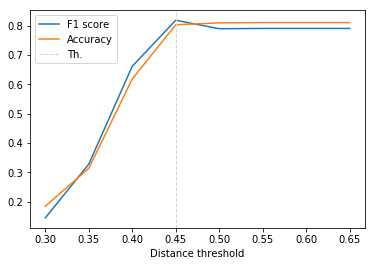

Optimal threshold: 0.45
F1-Score: [0.145089778953989, 0.32834222394002227, 0.6619780596748418, 0.81881411304981211, 0.78994252558934219, 0.79093556458469061, 0.79093556458469061, 0.79093556458469061]


In [25]:
opt_tau, f1, accuracy, labeled_name, predicted_name, all_distances, all_indices_th = \
    get_performance(3, np.arange(0.3, 0.7, 0.05), train_face_names, train_face_embeddings, eval_face_names_unk, eval_face_embeddings, "unknown")

print("Optimal threshold: " + str(opt_tau))
print("F1-Score: " + str(f1))

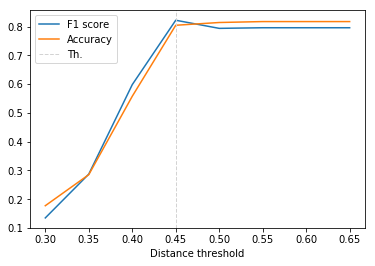

Optimal threshold: 0.45
F1-Score: [0.13492385503022672, 0.28711134037191438, 0.59809112209079629, 0.82195076561912384, 0.79371754240473746, 0.79588932751532437, 0.79588932751532437, 0.79588932751532437]


In [26]:
opt_tau, f1, accuracy, labeled_name, predicted_name, all_distances, all_indices_th = \
    get_performance(5, np.arange(0.3, 0.7, 0.05), train_face_names, train_face_embeddings, eval_face_names_unk, eval_face_embeddings, "unknown")

print("Optimal threshold: " + str(opt_tau))
print("F1-Score: " + str(f1))

## Error analysis

In [ ]:
unrecognized_errors = []
misclassified_errors = []
false_positive_errors = []

for test_idx, (tag, pred, distances, indexes) in enumerate(zip(labeled_name, predicted_name, all_distances, all_indices_th)):
    if tag != pred:
        if tag == "unknown":
            false_positive_errors.append((test_idx, distances, indexes))
        if tag != "unknown" and pred != "unknown":
            misclassified_errors.append((test_idx, distances, indexes))
        if pred == "unknown":
            unrecognized_errors.append((test_idx, distances, indexes))

print("-----------------------------------------------------------")
print(" => Unrecognized errors")
print("-----------------------------------------------------------")

for unrecognized_error in unrecognized_errors:
    test_idx, distances, indexes = unrecognized_error
    plt.imshow(plt.imread(local_path(eval_img_paths[test_idx])))
    plt.title("Idx: " + str(test_idx) + " " + eval_img_paths[test_idx].replace(tais_path_prefix,""))
    plt.xlabel(eval_img_sizes[test_idx])
    plt.show()

print("-----------------------------------------------------------")
print(" => Misclassified errors")
print("-----------------------------------------------------------")

for misclassified_error in misclassified_errors:
    test_idx, distances, indexes = misclassified_error
    f, ax = plt.subplots(1, 2, figsize=(10,6)) 
    ax[0].imshow( plt.imread(local_path(eval_img_paths[test_idx])) )
    ax[0].set_xlabel(eval_img_sizes[test_idx])
    ax[0].set_title("Idx: " + str(test_idx))
    ax[1].imshow( plt.imread(local_path(train_img_paths[indexes[0]])) )
    ax[1].set_xlabel(train_img_sizes[indexes[0]])
    ax[1].set_title("Idx: " + str(indexes[0]))
    plt.show()

print("-----------------------------------------------------------")
print(" => False positive errors")
print("-----------------------------------------------------------")

for false_positive_error in false_positive_errors:
    test_idx, distances, indexes = false_positive_error
    f, ax = plt.subplots(1, 2, figsize=(10,6)) 
    ax[0].imshow( plt.imread(local_path(eval_img_paths[test_idx])) )
    ax[0].set_xlabel(eval_img_sizes[test_idx])
    ax[0].set_title("Idx: " + str(test_idx))
    ax[1].imshow( plt.imread(local_path(train_img_paths[indexes[0]])) ) 
    ax[1].set_xlabel(train_img_sizes[indexes[0]])
    ax[1].set_title("Idx: " + str(indexes[0]))
    plt.show()

#### Error - size distribution

In [27]:
eval_errors = []
eval_errors.extend(unrecognized_errors)
eval_errors.extend(misclassified_errors)
eval_errors.extend(false_positive_errors)

eval_sizes = [ eval_img_sizes[idx] for idx, _, _ in eval_errors ]

train_errors = []
train_errors.extend(misclassified_errors)
train_errors.extend(false_positive_errors)
train_sizes = [ train_img_sizes[idx[0]] for _, _, idx in train_errors ]

error_sizes = eval_sizes
error_sizes.extend(train_sizes)
w_e, h_e = zip(*error_sizes)

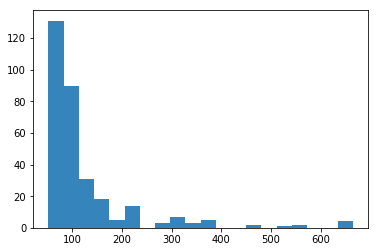

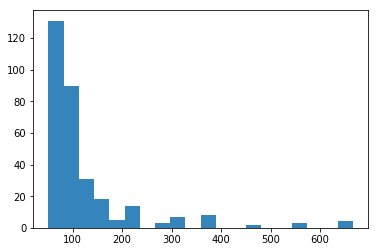

In [28]:
plt.hist(w_e, 20, alpha=0.9, density=False, label="Width - error distribution")
plt.show()

plt.hist(h_e, 20, alpha=0.9, density=False, label="Height - error distribution")
plt.show()

## Remove small faces

In [29]:
min_size = 110

In [30]:
idx_train_small = [i for i, (w,h) in enumerate(train_img_sizes) if w > min_size]

train_face_names = np.array(train_face_names)[idx_train_small].tolist()
train_face_embeddings = [e for i, e in enumerate(train_face_embeddings) if i in idx_train_small]
train_img_paths = np.array(train_img_paths)[idx_train_small].tolist()
train_img_sizes = np.array(train_img_sizes)[idx_train_small].tolist()

In [31]:
len(train_face_names)

3722

In [32]:
new_face_db = {}
new_face_db['names'] = train_face_names
new_face_db['embedding'] = train_face_embeddings
new_face_db['images_path'] = train_img_paths
new_face_db['sizes'] = train_img_sizes

In [33]:
with open(str("spaceai-evolution-train-v2-no-small.db"), 'wb') as fp:
    pickle.dump(new_face_db, fp)

In [34]:
idx_eval_small = [i for i, (w,h) in enumerate(eval_img_sizes) if w > min_size]

eval_face_names = np.array(eval_face_names)[idx_eval_small].tolist()
eval_face_names_unk = np.array(eval_face_names_unk)[idx_eval_small].tolist()
eval_face_embeddings = [e for i, e in enumerate(eval_face_embeddings) if i in idx_eval_small]
eval_img_paths = np.array(eval_img_paths)[idx_eval_small].tolist()
eval_img_sizes = np.array(eval_img_sizes)[idx_eval_small].tolist()

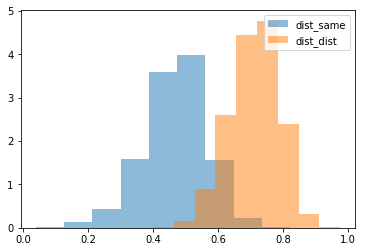

In [35]:
show_distances_distributions(train_face_names, train_face_embeddings)

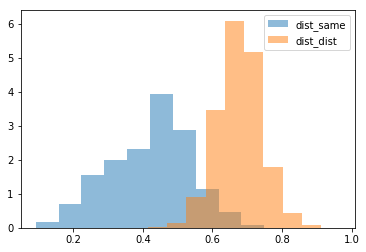

In [36]:
show_distances_distributions(eval_face_names, eval_face_embeddings)

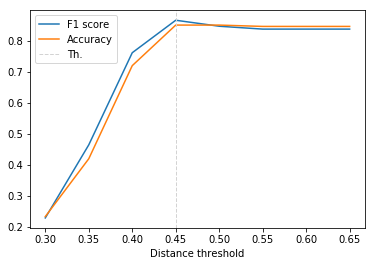

Optimal threshold0.45
F1-Score[0.22915977900689699, 0.4644423827775967, 0.76111402133392436, 0.86570473237732892, 0.84640663889841616, 0.83714940809472893, 0.83714940809472893, 0.83714940809472893]


In [37]:
opt_tau, f1, accuracy, labeled_name, predicted_name, all_distances, all_indices_th = \
    get_performance(1, np.arange(0.3, 0.7, 0.05), train_face_names, train_face_embeddings, eval_face_names_unk, eval_face_embeddings, "unknown")

print("Optimal threshold" + str(opt_tau))
print("F1-Score" + str(f1))

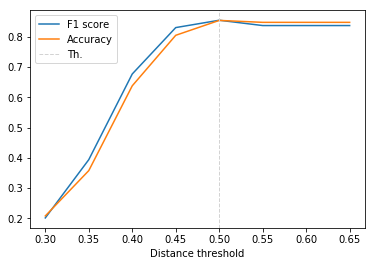

Optimal threshold0.5
F1-Score[0.20121316946705486, 0.39385551624203891, 0.67722742966563776, 0.83064487966296818, 0.8549242176250158, 0.83737434684093648, 0.83737434684093648, 0.83737434684093648]


In [38]:
opt_tau, f1, accuracy, labeled_name, predicted_name, all_distances, all_indices_th = \
    get_performance(3, np.arange(0.3, 0.7, 0.05), train_face_names, train_face_embeddings, eval_face_names_unk, eval_face_embeddings, "unknown")

print("Optimal threshold" + str(opt_tau))
print("F1-Score" + str(f1))

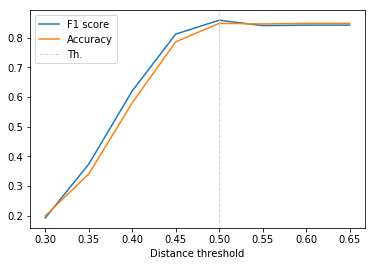

Optimal threshold0.5
F1-Score[0.19228412677697343, 0.37365700163263621, 0.62033311604462393, 0.81168245400001304, 0.85837638552449036, 0.84027873038082335, 0.84182971705521792, 0.84182971705521792]


In [39]:
opt_tau, f1, accuracy, labeled_name, predicted_name, all_distances, all_indices_th = \
    get_performance(5, np.arange(0.3, 0.7, 0.05), train_face_names, train_face_embeddings, eval_face_names_unk, eval_face_embeddings, "unknown")

print("Optimal threshold" + str(opt_tau))
print("F1-Score" + str(f1))

In [ ]:
unrecognized_errors = []
misclassified_errors = []
false_positive_errors = []

for test_idx, (tag, pred, distances, indexes) in enumerate(zip(labeled_name, predicted_name, all_distances, all_indices_th)):
    if tag != pred:
        if tag == "unknown":
            false_positive_errors.append((test_idx, distances, indexes))
        if tag != "unknown" and pred != "unknown":
            misclassified_errors.append((test_idx, distances, indexes))
        if pred == "unknown":
            unrecognized_errors.append((test_idx, distances, indexes))

print("-----------------------------------------------------------")
print(" => Unrecognized errors")
print("-----------------------------------------------------------")

for unrecognized_error in unrecognized_errors:
    test_idx, distances, indexes = unrecognized_error
    plt.imshow(plt.imread(local_path(eval_img_paths[test_idx])))
    plt.title("Idx: " + str(test_idx) + " " + eval_img_paths[test_idx].replace(tais_path_prefix,""))
    plt.xlabel(eval_img_sizes[test_idx])
    plt.show()

print("-----------------------------------------------------------")
print(" => Misclassified errors")
print("-----------------------------------------------------------")

for misclassified_error in misclassified_errors:
    test_idx, distances, indexes = misclassified_error
    f, ax = plt.subplots(1, 2, figsize=(10,6)) 
    ax[0].imshow( plt.imread(local_path(eval_img_paths[test_idx])) )
    ax[0].set_xlabel(eval_img_sizes[test_idx])
    ax[0].set_title("Idx: " + str(test_idx))
    ax[1].imshow( plt.imread(local_path(train_img_paths[indexes[0]])) )
    ax[1].set_xlabel(train_img_sizes[indexes[0]])
    ax[1].set_title("Idx: " + str(indexes[0]))
    plt.show()

print("-----------------------------------------------------------")
print(" => False positive errors")
print("-----------------------------------------------------------")

for false_positive_error in false_positive_errors:
    test_idx, distances, indexes = false_positive_error
    f, ax = plt.subplots(1, 2, figsize=(10,6)) 
    ax[0].imshow( plt.imread(local_path(eval_img_paths[test_idx])) )
    ax[0].set_xlabel(eval_img_sizes[test_idx])
    ax[0].set_title("Idx: " + str(test_idx))
    ax[1].imshow( plt.imread(local_path(train_img_paths[indexes[0]])) ) 
    ax[1].set_xlabel(train_img_sizes[indexes[0]])
    ax[1].set_title("Idx: " + str(indexes[0]))
    plt.show()

## Resize small faces

In [ ]:
def resize_small_faces(names, embedings, paths, sizes, min_size=110, to_size=200, model="hog"):
    out_names = []
    out_embedings = []
    out_paths = []
    out_sizes = []
    
    resized = 0
    
    for i, (name, emb, path, size) in enumerate(zip(names, embedings, paths, sizes)):
        w, h = size
        if w < min_size:
            resized +=1
            img = cv2.imread(local_path(path))
            ih, iw, _ = img.shape
            r = to_size/w
            img = cv2.resize(img,(int(r*iw), int(r*ih)))
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            
            try:
                l = face_recognition.face_locations(img_rgb, number_of_times_to_upsample=0, model=model)
                emb = face_recognition.face_encodings(img_rgb, l)[0]
            
                out_embedings.append(emb)
                out_sizes.append((int(r*w), int(r*h)))
                out_names.append(name)
                out_paths.append(path)
            except:
                print("Error getting embedding")
            
        else:
            out_names.append(name)
            out_embedings.append(emb)
            out_paths.append(path)
            out_sizes.append(sizes)

    print("Resized images: " + str(resized))
    return out_names, out_embedings, out_paths, out_sizes

In [ ]:
resized_train_face_names, resized_train_face_embeddings, resized_train_img_paths, resized_train_img_sizes = \
    resize_small_faces(train_face_names, train_face_embeddings, train_img_paths, train_img_sizes, 110)

In [ ]:
show_distances_distributions(resized_train_face_names, resized_train_face_embeddings)

In [ ]:
resized_eval_face_names, resized_eval_face_embeddings, resized_eval_img_paths, resized_eval_img_sizes = \
    resize_small_faces(eval_face_names, eval_face_embeddings, eval_img_paths, eval_img_sizes, 110)

In [ ]:
show_distances_distributions(resized_eval_face_names, resized_eval_face_embeddings)

In [ ]:
unknown_people = list(set(resized_eval_face_names) - set(train_face_names))
resized_eval_face_names_unk = ["unknown" if n in unknown_people else n for n in resized_eval_face_names]
set(resized_eval_face_names_unk)

In [ ]:
opt_tau, f1, accuracy, labeled_name, predicted_name, all_distances, all_indices_th = \
    get_performance(1, np.arange(0.3, 0.7, 0.05), resized_train_face_names, resized_train_face_embeddings, resized_eval_face_names_unk, resized_eval_face_embeddings, "unknown")

print("Optimal threshold" + str(opt_tau))
print("F1-Score" + str(f1))

In [ ]:
unrecognized_errors = []
misclassified_errors = []
false_positive_errors = []

for test_idx, (tag, pred, distances, indexes) in enumerate(zip(labeled_name, predicted_name, all_distances, all_indices_th)):
    if tag != pred:
        if tag == "unknown":
            false_positive_errors.append((test_idx, distances, indexes))
        if tag != "unknown" and pred != "unknown":
            misclassified_errors.append((test_idx, distances, indexes))
        if pred == "unknown":
            unrecognized_errors.append((test_idx, distances, indexes))

print("-----------------------------------------------------------")
print(" => Unrecognized errors")
print("-----------------------------------------------------------")

for unrecognized_error in unrecognized_errors:
    test_idx, distances, indexes = unrecognized_error
    plt.imshow(plt.imread(local_path(eval_img_paths[test_idx])))
    plt.title("Idx: " + str(test_idx) + " " + eval_img_paths[test_idx].replace(tais_path_prefix,""))
    plt.xlabel(eval_img_sizes[test_idx])
    plt.show()

print("-----------------------------------------------------------")
print(" => Misclassified errors")
print("-----------------------------------------------------------")

for misclassified_error in misclassified_errors:
    test_idx, distances, indexes = misclassified_error
    f, ax = plt.subplots(1, 2, figsize=(10,6)) 
    ax[0].imshow( plt.imread(local_path(eval_img_paths[test_idx])) )
    ax[0].set_xlabel(eval_img_sizes[test_idx])
    ax[0].set_title("Idx: " + str(test_idx))
    ax[1].imshow( plt.imread(local_path(train_img_paths[indexes[0]])) )
    ax[1].set_xlabel(train_img_sizes[indexes[0]])
    ax[1].set_title("Idx: " + str(indexes[0]))
    plt.show()

print("-----------------------------------------------------------")
print(" => False positive errors")
print("-----------------------------------------------------------")

for false_positive_error in false_positive_errors:
    test_idx, distances, indexes = false_positive_error
    f, ax = plt.subplots(1, 2, figsize=(10,6)) 
    ax[0].imshow( plt.imread(local_path(eval_img_paths[test_idx])) )
    ax[0].set_xlabel(eval_img_sizes[test_idx])
    ax[0].set_title("Idx: " + str(test_idx))
    ax[1].imshow( plt.imread(local_path(train_img_paths[indexes[0]])) ) 
    ax[1].set_xlabel(train_img_sizes[indexes[0]])
    ax[1].set_title("Idx: " + str(indexes[0]))
    plt.show()

## Faces landmarks analysis

In [ ]:
plt.imshow(plt.imread(local_path(eval_img_paths[925])))

In [ ]:
plt.imshow(plt.imread(local_path(eval_img_paths[921])))

In [ ]:
img_frontal = plt.imread(local_path(eval_img_paths[921]))
face_landmarks_frontal = face_recognition.face_landmarks(img_frontal)

In [ ]:
face_landmarks_frontal

In [ ]:
img_nofrontal = plt.imread(local_path(eval_img_paths[925]))
face_landmarks_nofrontal = face_recognition.face_landmarks(img_nofrontal)

In [ ]:
face_landmarks_nofrontal

In [ ]:
from PIL import Image, ImageDraw
import face_recognition

for face_landmarks in face_landmarks_frontal:
    pil_image = Image.fromarray(img_frontal)
    d = ImageDraw.Draw(pil_image, 'RGBA')

    # Make the eyebrows into a nightmare
    d.polygon(face_landmarks['left_eyebrow'], fill=(68, 54, 39, 128))
    d.polygon(face_landmarks['right_eyebrow'], fill=(68, 54, 39, 128))
    d.line(face_landmarks['left_eyebrow'], fill=(68, 54, 39, 150), width=5)
    d.line(face_landmarks['right_eyebrow'], fill=(68, 54, 39, 150), width=5)

    # Gloss the lips
    d.polygon(face_landmarks['top_lip'], fill=(150, 0, 0, 128))
    d.polygon(face_landmarks['bottom_lip'], fill=(150, 0, 0, 128))
    d.line(face_landmarks['top_lip'], fill=(150, 0, 0, 64), width=8)
    d.line(face_landmarks['bottom_lip'], fill=(150, 0, 0, 64), width=8)

    # Sparkle the eyes
    d.polygon(face_landmarks['left_eye'], fill=(255, 255, 255, 30))
    d.polygon(face_landmarks['right_eye'], fill=(255, 255, 255, 30))

    # Apply some eyeliner
    d.line(face_landmarks['left_eye'] + [face_landmarks['left_eye'][0]], fill=(0, 0, 0, 110), width=6)
    d.line(face_landmarks['right_eye'] + [face_landmarks['right_eye'][0]], fill=(0, 0, 0, 110), width=6)

pix = np.array(pil_image)
plt.imshow(pix)
plt.show()

In [ ]:
from PIL import Image, ImageDraw
import face_recognition

for face_landmarks in face_landmarks_nofrontal:
    pil_image = Image.fromarray(img_nofrontal)
    d = ImageDraw.Draw(pil_image, 'RGBA')

    # Make the eyebrows into a nightmare
    d.polygon(face_landmarks['left_eyebrow'], fill=(68, 54, 39, 128))
    d.polygon(face_landmarks['right_eyebrow'], fill=(68, 54, 39, 128))
    d.line(face_landmarks['left_eyebrow'], fill=(68, 54, 39, 150), width=5)
    d.line(face_landmarks['right_eyebrow'], fill=(68, 54, 39, 150), width=5)

    # Gloss the lips
    d.polygon(face_landmarks['top_lip'], fill=(150, 0, 0, 128))
    d.polygon(face_landmarks['bottom_lip'], fill=(150, 0, 0, 128))
    d.line(face_landmarks['top_lip'], fill=(150, 0, 0, 64), width=8)
    d.line(face_landmarks['bottom_lip'], fill=(150, 0, 0, 64), width=8)

    # Sparkle the eyes
    d.polygon(face_landmarks['left_eye'], fill=(255, 255, 255, 30))
    d.polygon(face_landmarks['right_eye'], fill=(255, 255, 255, 30))

    # Apply some eyeliner
    d.line(face_landmarks['left_eye'] + [face_landmarks['left_eye'][0]], fill=(0, 0, 0, 110), width=6)
    d.line(face_landmarks['right_eye'] + [face_landmarks['right_eye'][0]], fill=(0, 0, 0, 110), width=6)

pix = np.array(pil_image)
plt.imshow(pix)
plt.show()